In [1]:
import numpy as np
import scarlet
import logging
import tensorflow_hub as hub
import tensorflow as tf
logger = logging.getLogger('scarlet')
logger.setLevel(logging.DEBUG)

In [2]:
import proxmin
import proxmin.operators

In [6]:
class PixelCNNConstraint(scarlet.Constraint):
    
    def __init__(self, module, session):
        self.x = tf.placeholder(shape=(1,64,64,1), dtype=tf.float32)
        self.pixelcnn = module(self.x)
        self.session = session

    def prox_pixelcnn(self, X, step):
        print(X.shape)
        print(X)
        # This is messy, but the image is 65x65 instead of 64x64
        grad = self.session.run(self.pixelcnn, feed_dict={self.x: X.reshape((1,65,65,1))[:,1:,1:,:]})
        print(grad)
        res = X
        res[1:, 1:] = res[1:, 1:] + step*grad[0,:,:,0]
        return res

    def prox_sed(self, shape):
        return proxmin.operators.prox_plus

    def prox_morph(self, shape):
        return proxmin.operators.AlternatingProjections([
            self.prox_pixelcnn,
            proxmin.operators.prox_unity,
        ])

In [4]:
module_path='modules/pixelcnn_gradients'
pixelcnn = hub.Module(module_path)
sess= tf.Session()
sess.run(tf.global_variables_initializer())
x = tf.placeholder(shape=(1,64,64,1), dtype=tf.float32)

In [16]:
# quick test of the gradient module
%pylab inline
im = 0.01*randn(1,64,64,1)
im0 = im+0
grads = pixelcnn(x)

Populating the interactive namespace from numpy and matplotlib


In [20]:
for i in range(1000):
    d = sess.run(grads, feed_dict={x: im})
    im -= 0.001*d/(64.*64)

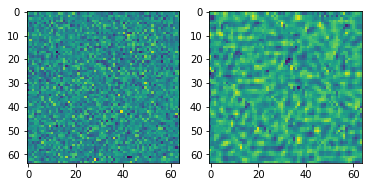

In [21]:
# It reproduces more or less the noise correlation learned from training
subplot(121)
imshow(im0[0,:,:,0])
subplot(122)
imshow(im[0,:,:,0])

In [ ]:
data = np.load("../scarlet/data/test_sim/data.npz")
img = data["images"]
filters = data["filters"]

# open file and perform detection
B = len(img)

from astropy.table import Table as ApTable
catalog = ApTable.read("../scarlet/data/test_sim/true_catalog.fits")
bg_rms = np.array([1e-3]*len(img))

# run scarlet
config = scarlet.Config(source_sizes=[64], accelerated=True)
sources = [scarlet.ExtendedSource((obj['y'],obj['x']), img, bg_rms, normalization=scarlet.Normalization.S, config=config, constraints=PixelCNNConstraint(pixelcnn, sess)) for obj in catalog]
blend = scarlet.Blend(sources).set_data(img, config=config).fit(100, e_rel=1e-4)

plt.figure()
plt.plot(blend.mse)
plt.show()

plt.figure()
plt.imshow(blend.get_model()[0])
plt.show()

(65, 65)
[[        nan         nan  0.         ...         nan         nan
          nan]
 [        nan         nan  0.         ...         nan         nan
          nan]
 [        nan         nan  0.         ...         nan         nan
          nan]
 ...
 [        nan         nan -0.01700351 ...         nan         nan
          nan]
 [        nan         nan -0.10939575 ...         nan         nan
          nan]
 [        nan         nan -0.04325348 ...         nan         nan
          nan]]
[[[[nan]
   [nan]
   [nan]
   ...
   [nan]
   [nan]
   [nan]]

  [[nan]
   [nan]
   [nan]
   ...
   [nan]
   [nan]
   [nan]]

  [[nan]
   [nan]
   [nan]
   ...
   [nan]
   [nan]
   [nan]]

  ...

  [[nan]
   [nan]
   [nan]
   ...
   [nan]
   [nan]
   [nan]]

  [[nan]
   [nan]
   [nan]
   ...
   [nan]
   [nan]
   [nan]]

  [[nan]
   [nan]
   [nan]
   ...
   [nan]
   [nan]
   [nan]]]]
(65, 65)
[[        nan         nan         nan ... -0.00440614 -0.0046151
          nan]
 [        nan         na